In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

from skimage import data, img_as_float, exposure
from skimage.color import rgb2grey
from skimage.feature import corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform, warp
from skimage.measure import ransac

%matplotlib notebook

In [2]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # SVD (singular value decomposition) for (Nx2) matrix A = U*diag(S)*V  where N is the number of points
        # matrix V is 2x2, matrix U is Nx2, and S is a vector (Nx1 array) of eigen values for A
        u,s,v = la.svd(A, full_matrices=False)

        #least square line fit = v' * 1/s * u' * B
        ls_line = np.transpose(v).dot(np.diag(1.0/s)).dot(np.transpose(u).dot(B))
        self.a = ls_line[0]
        self.b = ls_line[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

<IPython.core.display.Javascript object>


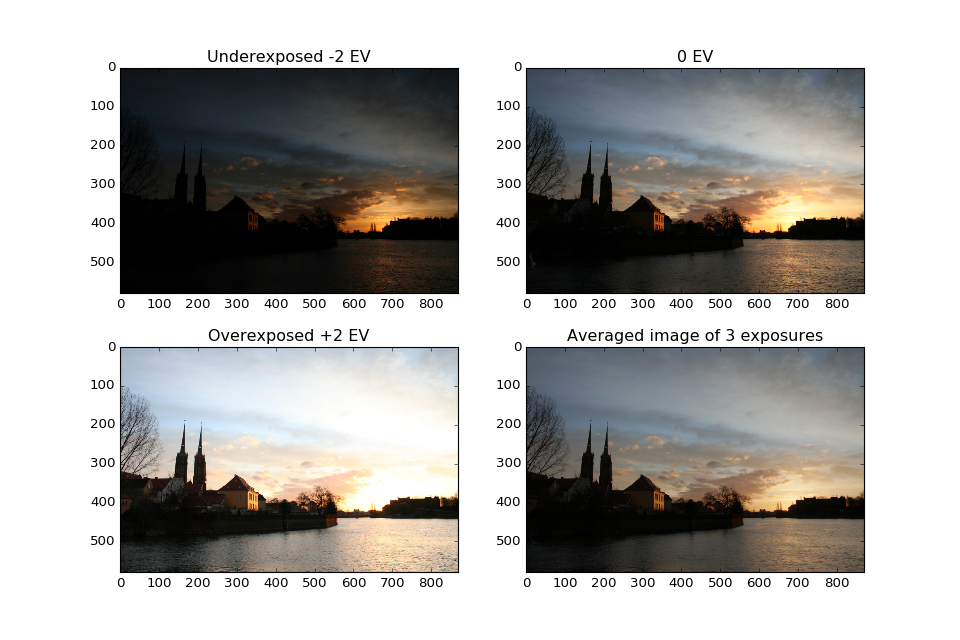

In [3]:
im1 = img_as_float(image.imread("images/ostrow_tumski1.jpg"))
im2 = img_as_float(image.imread("images/ostrow_tumski2.jpg"))
im3 = img_as_float(image.imread("images/ostrow_tumski3.jpg"))
im_orig = image.imread("images/ostrow_tumski.jpg")

# Show results of simple averaging
fig = plt.figure(1,figsize=(12,8))

ax1 = plt.subplot(221)
plt.imshow(im1)
plt.title("Underexposed -2 EV")

ax2 = plt.subplot(222)
plt.imshow(im2)
plt.title("0 EV")

ax3 = plt.subplot(223)
plt.imshow(im3)
plt.title("Overexposed +2 EV")

# Float-valued averaging of all three images
im4 = im1*0.33 + im2*0.33 + im3*0.33
ax4 = plt.subplot(224)
plt.imshow(im4)
plt.title("Averaged image of 3 exposures")

plt.show()

C:\Users\JLee\Anaconda2\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


<IPython.core.display.Javascript object>


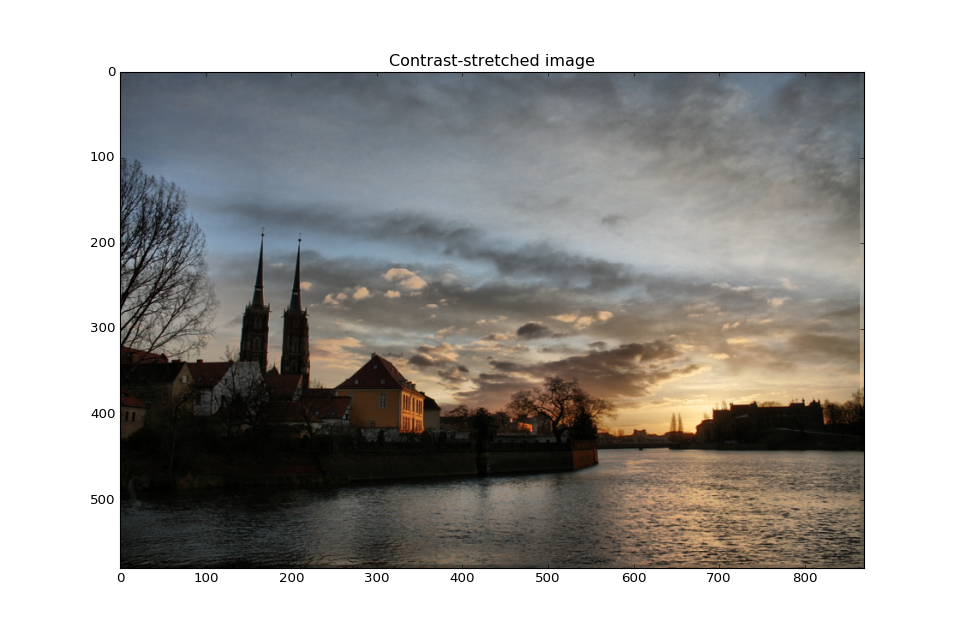

<IPython.core.display.Javascript object>


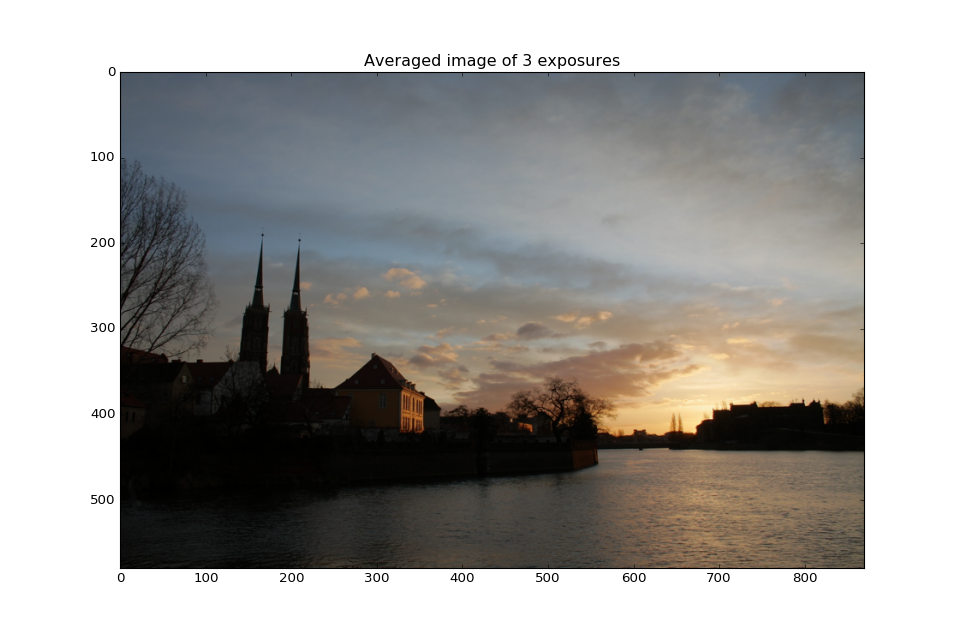

In [4]:
# Applying histogram equalization
im_adpteq = exposure.equalize_adapthist(im4)
fig = plt.figure(2,figsize=(12,8))
plt.subplot(111)
plt.imshow(im_adpteq)
plt.title("Contrast-stretched image")

plt.figure(3,figsize=(12,8))
plt.subplot(111)
plt.title("Averaged image of 3 exposures")
plt.imshow(im4)

plt.show()

Comparing, the contrast-stretched image to the averaged image, you can clearly see additional detail along the closer shoreline and the sky. However, compared to professional grade HDR, there is a significant difference not only in the visibility and color of the closer shoreline, but also of the farther shoreline (which is now easily visible) as well as in the contrast in the sky

<IPython.core.display.Javascript object>


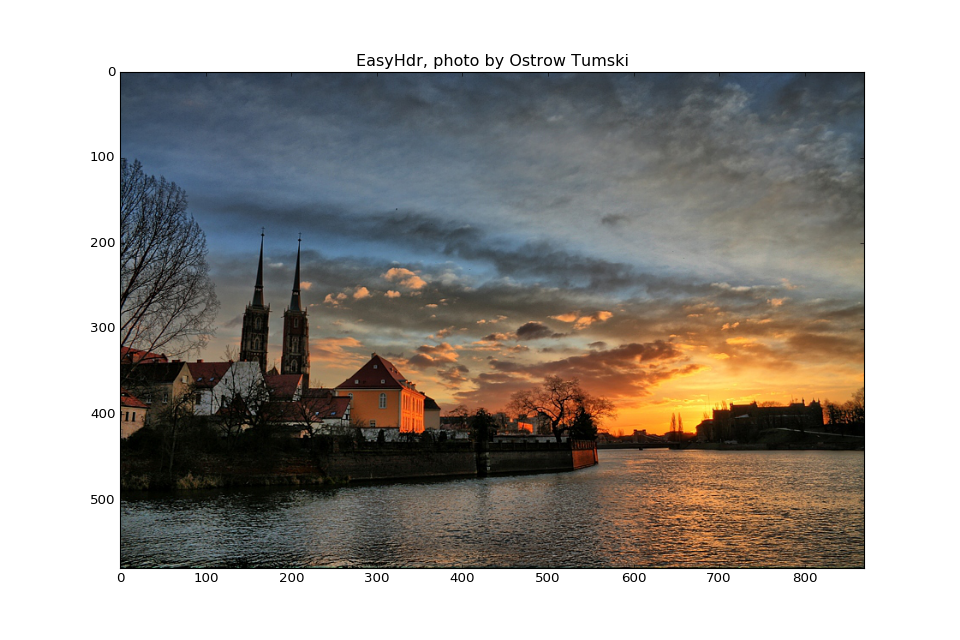

In [5]:
plt.figure(4, figsize=(12,8))
plt.subplot(111)
plt.imshow(im_orig)
plt.title("EasyHdr, photo by Ostrow Tumski")
plt.show()

In [6]:
def keypointExtraction(img, keypoints, extractor):
    extractor.extract(img, keypoints)
    tmpKeyPoints = keypoints[extractor.mask]
    return extractor.descriptors, extractor.mask
    

In [7]:
# Returns an image of B that is warped to A using both Affine and Projective transforms
def ransacPoints(imgA, imgB, extractor):
    imgA_grey = rgb2grey(imgA)
    imgB_grey = rgb2grey(imgB)
    keypointsA = corner_peaks(corner_harris(imgA_grey), threshold_rel=0.0005, min_distance=5)
    keypointsB = corner_peaks(corner_harris(imgB_grey), threshold_rel=0.0005, min_distance=5)
    
    descriptorsA, maskA = keypointExtraction(imgA_grey, keypointsA, extractor)
    descriptorsB, maskB = keypointExtraction(imgB_grey, keypointsB, extractor)
    
    matches = match_descriptors(descriptorsA, descriptorsB, cross_check=True)
    model_robust, inliers = ransac(matches, LeastSquareLine, min_samples=4, residual_threshold=1, max_trials=1000)
    
    ll = []
    for inlier in np.where(inliers)[0]:
        ll.append(matches[inlier])
    
    tmpMaskA = np.where(maskA)[0]
    tmpMaskB = np.where(maskB)[0]
    
    inA = []
    inB = []
    
    for x, y in ll:
        inA.append(tmpMaskA[x])
        inB.append(tmpMaskB[y])
    
    tmpPtsA = []
    tmpPtsB = []
    
    for i in inA:
        tmpPtsA.append(keypointsA[i])

    for j in inB:
        tmpPtsB.append(keypointsB[j])
    
    ptsA = np.array(tmpPtsA)
    ptsB = np.array(tmpPtsB)
    
    AffLtoR = AffineTransform()
    AffLtoR.estimate(ptsA, ptsB)

    PrjLtoR = ProjectiveTransform()
    PrjLtoR.estimate(ptsA, ptsB)

    shapeRef = imgA.shape
    RprjRef = warp(imgB, PrjLtoR, output_shape = shapeRef)
    RaffRef = warp(imgB, AffLtoR, output_shape = shapeRef)
    
    return RprjRef, RaffRef
    

<IPython.core.display.Javascript object>


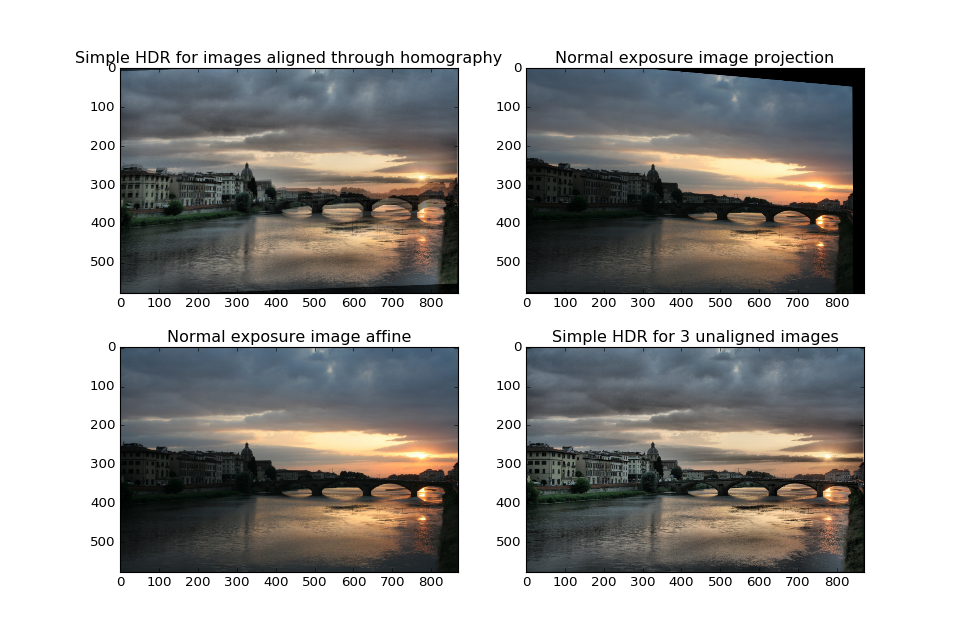

In [8]:
arno1 = rgb2grey(img_as_float(image.imread("images/arno1.jpg")))
arno2 = rgb2grey(img_as_float(image.imread("images/arno2.jpg")))
arno3 = rgb2grey(img_as_float(image.imread("images/arno3.jpg")))
arno = img_as_float(image.imread("images/arno.jpg"))

arno1_col = img_as_float(image.imread("images/arno1.jpg"))
arno2_col = img_as_float(image.imread("images/arno2.jpg"))
arno3_col = img_as_float(image.imread("images/arno3.jpg"))

extractor = BRIEF()
arno2Prj, arno2Aff = ransacPoints(arno1_col, arno2_col, extractor)
arno3Prj, arno3Aff = ransacPoints(arno1_col, arno3_col, extractor)
plt.figure(5, figsize=(12,8))
plt.subplot(221)
plt.imshow(exposure.equalize_adapthist(arno1_col*0.33 + arno2Aff*0.33 + arno3Aff*0.33))
plt.title("Simple HDR for images aligned through homography")

plt.subplot(222)
plt.imshow(arno2Prj)
plt.title("Normal exposure image projection")

plt.subplot(223)
plt.imshow(arno2Aff)
plt.title("Normal exposure image affine")

plt.subplot(224)
plt.imshow(exposure.equalize_adapthist(arno1_col*0.33 + arno2_col*0.33 + arno3_col*0.33))
plt.title("Simple HDR for 3 unaligned images")

plt.show()

Attempted to implement image alignment through homography - seeing the significant blurriness and misalignmentin the blended Affine transformation and the prospective Projective transform, a correct alignment does not seem to have been obtained. Am unsure if it is from improper implementation of RANSAC for robust homography fitting or RANSAC settings need tweaking in a direction I am unsure of.